In [1]:
# prompt: mount to drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/DL/May2025/BT_01
%ls

/content/drive/MyDrive/DL/May2025/BT_01
attentionU_net.ipynb  mask/                        segmentation_bce.ipynb
data/                 segmentation_bce+dice.ipynb


In [3]:
!pip install -q torchinfo accelerate tqdm



In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchinfo import summary
from torch import Tensor
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch.optim as optim

In [5]:


class SegmentationDataset(Dataset):
    def __init__(self, data_dir, mask_dir, transform=None, target_transform=None):
        self.data_dir = data_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_filenames = sorted(os.listdir(data_dir))  # đảm bảo thứ tự trùng nhau

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace("X_", "Y_"))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # nhãn thường là ảnh đơn kênh

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

# Ví dụ cách sử dụng
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = SegmentationDataset(data_dir='data', mask_dir='mask',
                               transform=transform, target_transform=target_transform)
train_ds, val_ds = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])

train_dataloader = DataLoader(train_ds, batch_size=16)
val_dataloader = DataLoader(val_ds, batch_size=16, shuffle=True)

# Duyệt thử một batch
for images, masks in train_dataloader:
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)
    break


Image batch shape: torch.Size([16, 3, 224, 224])
Mask batch shape: torch.Size([16, 1, 224, 224])


In [6]:
for _, mask in train_dataloader:
    print("Mask unique values:", torch.unique(mask))
    break

Mask unique values: tensor([0., 1.])


In [7]:
from __future__ import print_function, division
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch

class conv_block(nn.Module):
    """
    Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x

class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    """
    Attention Block
    """

    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out


class AttU_Net(nn.Module):
    """
    Attention Unet implementation
    Paper: https://arxiv.org/abs/1804.03999
    """
    def __init__(self, img_ch=3, output_ch=1):
        super(AttU_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)

        #self.active = torch.nn.Sigmoid()


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        #print(x5.shape)
        d5 = self.Up5(e5)
        #print(d5.shape)
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

      #  out = self.active(out)

        return out

summary(AttU_Net(), input_data=images)

Layer (type:depth-idx)                   Output Shape              Param #
AttU_Net                                 [16, 1, 224, 224]         --
├─conv_block: 1-1                        [16, 64, 224, 224]        --
│    └─Sequential: 2-1                   [16, 64, 224, 224]        --
│    │    └─Conv2d: 3-1                  [16, 64, 224, 224]        1,792
│    │    └─BatchNorm2d: 3-2             [16, 64, 224, 224]        128
│    │    └─ReLU: 3-3                    [16, 64, 224, 224]        --
│    │    └─Conv2d: 3-4                  [16, 64, 224, 224]        36,928
│    │    └─BatchNorm2d: 3-5             [16, 64, 224, 224]        128
│    │    └─ReLU: 3-6                    [16, 64, 224, 224]        --
├─MaxPool2d: 1-2                         [16, 64, 112, 112]        --
├─conv_block: 1-3                        [16, 128, 112, 112]       --
│    └─Sequential: 2-2                   [16, 128, 112, 112]       --
│    │    └─Conv2d: 3-7                  [16, 128, 112, 112]       73,856
│ 

In [8]:
import torch

def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = torch.flatten(y_true)
    y_pred_flatten = torch.flatten(y_pred)

    intersection = torch.sum(y_true_flatten * y_pred_flatten)
    union = torch.sum(y_true_flatten) + torch.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = torch.sum(y_true * y_pred)
    sum = torch.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [9]:
bce_loss = nn.BCELoss()

def criterion(y_pred, y_true):
    bce = bce_loss(y_pred, y_true)
    dice = dice_loss(y_true, y_pred)
    return bce + dice


In [10]:
model = AttU_Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model

AttU_Net(
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affi

In [11]:
def evaluate(model, dataloader):
    model.eval()
    val_loss = 0.0
    dice_total = 0.0
    iou_total = 0.0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            outputs = torch.sigmoid(outputs)

            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = (outputs > 0.5).float()

            dice_total += dice_coef(masks, preds).item()
            iou_total += iou_coef(masks, preds).item()

    val_loss /= len(dataloader)
    dice_total /= len(dataloader)
    iou_total /= len(dataloader)

    return val_loss, dice_total, iou_total


In [12]:
val_losses = []
val_dice_scores = []
val_iou_scores = []

epochs = 60

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_dataloader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        outputs = torch.sigmoid(outputs)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    val_loss, dice, iou = evaluate(model, val_dataloader)

    val_losses.append(val_loss)
    val_dice_scores.append(dice)
    val_iou_scores.append(iou)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Dice: {dice:.4f} | IoU: {iou:.4f}")


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Epoch [1/60] Train Loss: -0.1206 | Val Loss: 4.0558 | Dice: 0.0006 | IoU: 0.0006


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Epoch [2/60] Train Loss: -0.3286 | Val Loss: 0.6426 | Dice: 0.2402 | IoU: 0.1394


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [3/60] Train Loss: -0.4165 | Val Loss: 1.0984 | Dice: 0.5771 | IoU: 0.4082


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


Epoch [4/60] Train Loss: -0.5084 | Val Loss: -0.3846 | Dice: 0.7752 | IoU: 0.6370


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


Epoch [5/60] Train Loss: -0.5319 | Val Loss: -0.4782 | Dice: 0.8319 | IoU: 0.7131


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Epoch [6/60] Train Loss: -0.5639 | Val Loss: -0.5579 | Dice: 0.8556 | IoU: 0.7485


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [7/60] Train Loss: -0.6039 | Val Loss: -0.6407 | Dice: 0.8834 | IoU: 0.7917


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [8/60] Train Loss: -0.5995 | Val Loss: -0.6689 | Dice: 0.8887 | IoU: 0.7999


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Epoch [9/60] Train Loss: -0.6139 | Val Loss: -0.6893 | Dice: 0.9010 | IoU: 0.8207


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [10/60] Train Loss: -0.6083 | Val Loss: -0.6062 | Dice: 0.8716 | IoU: 0.7732


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [11/60] Train Loss: -0.6441 | Val Loss: -0.7078 | Dice: 0.9098 | IoU: 0.8353


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [12/60] Train Loss: -0.6419 | Val Loss: -0.6695 | Dice: 0.8919 | IoU: 0.8054


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [13/60] Train Loss: -0.6637 | Val Loss: -0.6952 | Dice: 0.8940 | IoU: 0.8095


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Epoch [14/60] Train Loss: -0.6226 | Val Loss: -0.5998 | Dice: 0.8707 | IoU: 0.7720


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [15/60] Train Loss: -0.6692 | Val Loss: -0.6707 | Dice: 0.8915 | IoU: 0.8045


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Epoch [16/60] Train Loss: -0.6538 | Val Loss: -0.5363 | Dice: 0.8490 | IoU: 0.7377


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Epoch [17/60] Train Loss: -0.6789 | Val Loss: -0.7076 | Dice: 0.8973 | IoU: 0.8138


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [18/60] Train Loss: -0.6947 | Val Loss: -0.7339 | Dice: 0.9144 | IoU: 0.8429


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [19/60] Train Loss: -0.7084 | Val Loss: -0.7430 | Dice: 0.9131 | IoU: 0.8410


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [20/60] Train Loss: -0.7188 | Val Loss: -0.7675 | Dice: 0.9232 | IoU: 0.8576


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [21/60] Train Loss: -0.7129 | Val Loss: -0.7550 | Dice: 0.9175 | IoU: 0.8478


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Epoch [22/60] Train Loss: -0.6949 | Val Loss: -0.7289 | Dice: 0.9073 | IoU: 0.8304


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [23/60] Train Loss: -0.7076 | Val Loss: -0.7194 | Dice: 0.8984 | IoU: 0.8161


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [24/60] Train Loss: -0.7566 | Val Loss: -0.7342 | Dice: 0.9076 | IoU: 0.8333


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [25/60] Train Loss: -0.7386 | Val Loss: -0.7712 | Dice: 0.9240 | IoU: 0.8590


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [26/60] Train Loss: -0.7613 | Val Loss: -0.7717 | Dice: 0.9229 | IoU: 0.8571


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [27/60] Train Loss: -0.7516 | Val Loss: -0.7702 | Dice: 0.9212 | IoU: 0.8541


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [28/60] Train Loss: -0.7591 | Val Loss: -0.7845 | Dice: 0.9271 | IoU: 0.8641


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [29/60] Train Loss: -0.7610 | Val Loss: -0.7283 | Dice: 0.9073 | IoU: 0.8316


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [30/60] Train Loss: -0.7547 | Val Loss: -0.7832 | Dice: 0.9261 | IoU: 0.8624


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [31/60] Train Loss: -0.7719 | Val Loss: -0.7332 | Dice: 0.9122 | IoU: 0.8396


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [32/60] Train Loss: -0.7810 | Val Loss: -0.7728 | Dice: 0.9240 | IoU: 0.8591


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [33/60] Train Loss: -0.7693 | Val Loss: -0.7846 | Dice: 0.9257 | IoU: 0.8617


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [34/60] Train Loss: -0.7981 | Val Loss: -0.8008 | Dice: 0.9348 | IoU: 0.8777


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [35/60] Train Loss: -0.8023 | Val Loss: -0.7746 | Dice: 0.9199 | IoU: 0.8523


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [36/60] Train Loss: -0.8058 | Val Loss: -0.8114 | Dice: 0.9322 | IoU: 0.8732


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [37/60] Train Loss: -0.8091 | Val Loss: -0.7840 | Dice: 0.9259 | IoU: 0.8623


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [38/60] Train Loss: -0.8160 | Val Loss: -0.7649 | Dice: 0.9204 | IoU: 0.8532


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [39/60] Train Loss: -0.7968 | Val Loss: -0.7806 | Dice: 0.9234 | IoU: 0.8579


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [40/60] Train Loss: -0.7864 | Val Loss: -0.7522 | Dice: 0.9105 | IoU: 0.8360


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [41/60] Train Loss: -0.7742 | Val Loss: -0.7546 | Dice: 0.9132 | IoU: 0.8403


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [42/60] Train Loss: -0.7770 | Val Loss: -0.7886 | Dice: 0.9242 | IoU: 0.8593


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [43/60] Train Loss: -0.8089 | Val Loss: -0.6491 | Dice: 0.8860 | IoU: 0.7954


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [44/60] Train Loss: -0.8262 | Val Loss: -0.8123 | Dice: 0.9355 | IoU: 0.8789


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Epoch [45/60] Train Loss: -0.8312 | Val Loss: -0.7925 | Dice: 0.9250 | IoU: 0.8619


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [46/60] Train Loss: -0.8373 | Val Loss: -0.7262 | Dice: 0.9132 | IoU: 0.8429


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [47/60] Train Loss: -0.8543 | Val Loss: -0.7611 | Dice: 0.9145 | IoU: 0.8431


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [48/60] Train Loss: -0.8595 | Val Loss: -0.8084 | Dice: 0.9334 | IoU: 0.8754


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [49/60] Train Loss: -0.8139 | Val Loss: -0.7448 | Dice: 0.9077 | IoU: 0.8326


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [50/60] Train Loss: -0.7980 | Val Loss: -0.7080 | Dice: 0.9027 | IoU: 0.8240


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Epoch [51/60] Train Loss: -0.7472 | Val Loss: -0.7856 | Dice: 0.9287 | IoU: 0.8679


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [52/60] Train Loss: -0.7923 | Val Loss: -0.7748 | Dice: 0.9244 | IoU: 0.8599


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [53/60] Train Loss: -0.7350 | Val Loss: -0.5986 | Dice: 0.8648 | IoU: 0.7627


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [54/60] Train Loss: -0.7868 | Val Loss: -0.7355 | Dice: 0.9100 | IoU: 0.8362


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [55/60] Train Loss: -0.8191 | Val Loss: -0.7926 | Dice: 0.9289 | IoU: 0.8674


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Epoch [56/60] Train Loss: -0.8447 | Val Loss: -0.8012 | Dice: 0.9305 | IoU: 0.8702


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [57/60] Train Loss: -0.8589 | Val Loss: -0.8118 | Dice: 0.9348 | IoU: 0.8777


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [58/60] Train Loss: -0.8725 | Val Loss: -0.8190 | Dice: 0.9381 | IoU: 0.8840


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch [59/60] Train Loss: -0.8822 | Val Loss: -0.7840 | Dice: 0.9279 | IoU: 0.8656


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Epoch [60/60] Train Loss: -0.8853 | Val Loss: -0.8057 | Dice: 0.9330 | IoU: 0.8749


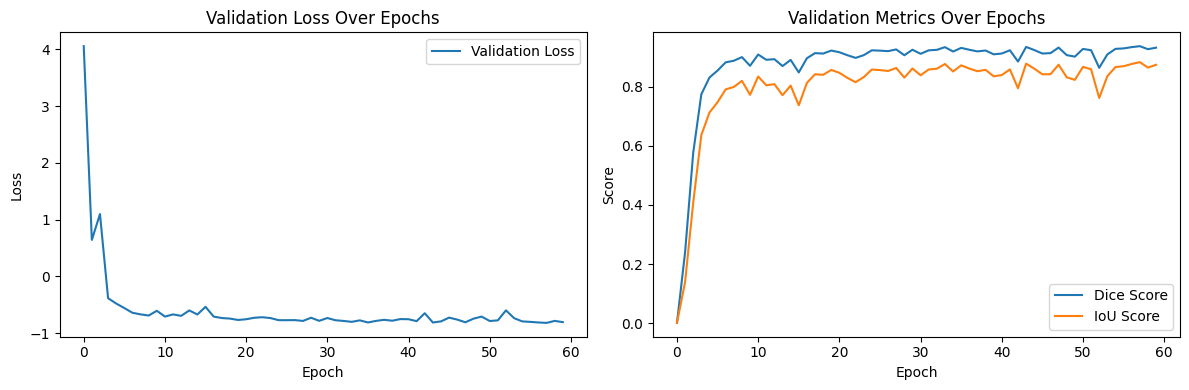

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(val_dice_scores, label='Dice Score')
plt.plot(val_iou_scores, label='IoU Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Validation Metrics Over Epochs')

plt.tight_layout()
plt.show()


In [14]:
# prompt: hiển thị 10 ảnh được dự đoán trong tập val

def display_predictions(model, dataloader, num_images=10):
    model.eval()
    images_displayed = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            predicted_masks = torch.sigmoid(outputs)
            predicted_masks = (predicted_masks > 0.5).float()

            for i in range(images.shape[0]):
                if images_displayed >= num_images:
                    return

                fig, axes = plt.subplots(1, 3, figsize=(15, 5))

                # Original Image
                img_np = images[i].cpu().permute(1, 2, 0).numpy()
                axes[0].imshow(img_np)
                axes[0].set_title('Original Image')
                axes[0].axis('off')

                # Ground Truth Mask
                mask_np = masks[i].cpu().squeeze().numpy()
                axes[1].imshow(mask_np, cmap='gray')
                axes[1].set_title('Ground Truth Mask')
                axes[1].axis('off')

                # Predicted Mask
                pred_mask_np = predicted_masks[i].cpu().squeeze().numpy()
                axes[2].imshow(pred_mask_np, cmap='gray')
                axes[2].set_title('Predicted Mask')
                axes[2].axis('off')

                plt.tight_layout()
                plt.show()

                images_displayed += 1

# Hiển thị 10 ảnh được dự đoán trong tập val
display_predictions(model, val_dataloader, num_images=10)


Output hidden; open in https://colab.research.google.com to view.